In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [3]:
df_in = pd.read_csv('Austin_Animal_Center_Intakes.csv')
df_in.head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A665644,NaN,10/21/2013 07:59:00 AM,October 2013,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico
1,A665739,*Alana,10/22/2013 11:11:00 AM,October 2013,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black
2,A665763,NaN,10/22/2013 03:10:00 PM,October 2013,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White
3,A379998,Disciple,10/23/2013 11:42:00 AM,October 2013,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black
4,A634503,Otter,10/01/2013 02:49:00 PM,October 2013,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan


# Preparing the data

In [4]:
df_out = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
df_out.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


In [63]:
# TODO 1: join the intake data with the outcome data;
# include date and location it was found, intake type and condition,
# and whether it was neutered/spayed or not at intake

In [77]:
# TODO 2: find the unique type-subtype pairs. Right now it just shows them all
type_subtype_pairing = df_out[['Outcome Type', 'Outcome Subtype']]
outcome_type = df_out['Outcome Type']
outcome_subtype = df_out['Outcome Subtype']

unique_types = outcome_type.unique()
unique_subtypes = outcome_subtype.unique()

# Unique type-subtype pairings, such as 'Adoption' and 'Foster'
unique_pairings = []

# for i in range(len(outcome_subtype)):
#     # print('type = {}, and subtype = {}'.format(outcome_type[i], outcome_subtype[i]))
#     unique_types.add(outcome_type[i])
#     unique_subtypes.add(outcome_subtype[i])

print("Unique types of outcomes - ", unique_types.tolist())
print("Unique sub-types of outcomes - ", unique_subtypes.tolist())

total_cases = 0
for outcomeType in unique_types:
    outcome_count = len(type_subtype_pairing.loc[type_subtype_pairing['Outcome Type'] == outcomeType])
    total_cases += outcome_count
    print('Number of cases where the outcome is {} is {}'.format(outcomeType, outcome_count))

print('The total number of cases is', total_cases)

print('\n\nType-Subtype pairing -\n', type_subtype_pairing)

Unique types of outcomes -  ['Rto-Adopt', 'Adoption', 'Euthanasia', 'Transfer', 'Return to Owner', 'Died', 'Disposal', 'Missing', 'Relocate', <NA>, 'Stolen']
Unique sub-types of outcomes -  [<NA>, 'Partner', 'Foster', 'SCRP', 'Out State', 'Suffering', 'Underage', 'Snr', 'Rabies Risk', 'In Kennel', 'Offsite', 'Aggressive', 'Enroute', 'At Vet', 'In Foster', 'Field', 'Behavior', 'Medical', 'Possible Theft', 'Barn', 'Customer S', 'Court/Investigation', 'Emer', 'In Surgery', 'Prc', 'Emergency', 'In State']
Number of cases where the outcome is Rto-Adopt is 1003
Number of cases where the outcome is Adoption is 69764
Number of cases where the outcome is Euthanasia is 9667
Number of cases where the outcome is Transfer is 42941
Number of cases where the outcome is Return to Owner is 23930
Number of cases where the outcome is Died is 1399
Number of cases where the outcome is Disposal is 678
Number of cases where the outcome is Missing is 75
Number of cases where the outcome is Relocate is 26
Numb

In [8]:
df_out = df_out.convert_dtypes(infer_objects=True)
df_out['DateTime'] = pd.to_datetime(df_out['DateTime'])
df_out['Date of Birth'] = pd.to_datetime(df_out['Date of Birth'])
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149511 entries, 0 to 149510
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         149511 non-null  string        
 1   Name              106260 non-null  string        
 2   DateTime          149511 non-null  datetime64[ns]
 3   MonthYear         149511 non-null  string        
 4   Date of Birth     149511 non-null  datetime64[ns]
 5   Outcome Type      149485 non-null  string        
 6   Outcome Subtype   68443 non-null   string        
 7   Animal Type       149511 non-null  string        
 8   Sex upon Outcome  149509 non-null  string        
 9   Age upon Outcome  149465 non-null  string        
 10  Breed             149511 non-null  string        
 11  Color             149511 non-null  string        
dtypes: datetime64[ns](2), string(10)
memory usage: 13.7 MB


## Name

In [9]:
# TODO 3: set df_out['Name'] so that if it had an asterisk in front, the asterisk is removed
df_out['Name']

0              Chunk
1              Gizmo
2               <NA>
3              Moose
4               <NA>
             ...    
149506    *Lady Gaga
149507        *Suede
149508         Queen
149509       A852775
149510       A854626
Name: Name, Length: 149511, dtype: string

## Colors

In [10]:
from math import pi

# colors.csv was compiled from these wikipedia articles
# https://en.wikipedia.org/wiki/List_of_colors:_A–F
# https://en.wikipedia.org/wiki/List_of_colors:_G%E2%80%93M
# https://en.wikipedia.org/wiki/List_of_colors:_N%E2%80%93Z
# Then the "—" character was replaced with "0"
df_colors = pd.read_csv('colors.csv')
df_colors = df_colors.convert_dtypes(infer_objects=True)
df_colors['Name'] = df_colors['Name'].str.lower()
df_colors['Red (RGB)'] = pd.to_numeric(df_colors['Red (RGB)'].str.replace('%', '')).div(100)
df_colors['Green (RGB)'] = pd.to_numeric(df_colors['Green (RGB)'].str.replace('%', '')).div(100)
df_colors['Blue (RGB)'] = pd.to_numeric(df_colors['Blue (RGB)'].str.replace('%', '')).div(100)
df_colors['Hue (HSL/HSV)'] = pd.to_numeric(df_colors['Hue (HSL/HSV)'].str.replace('°', '')).div(360)
df_colors['Satur. (HSL)'] = pd.to_numeric(df_colors['Satur. (HSL)'].str.replace('%', '')).div(100)
df_colors['Light (HSL)'] = pd.to_numeric(df_colors['Light (HSL)'].str.replace('%', '')).div(100)
df_colors['Satur. (HSV)'] = pd.to_numeric(df_colors['Satur. (HSV)'].str.replace('%', '')).div(100)
df_colors['Value (HSV)'] = pd.to_numeric(df_colors['Value (HSV)'].str.replace('%', '')).div(100)
df_colors.head()

,Name,Hex (RGB),Red (RGB),Green (RGB),Blue (RGB),Hue (HSL/HSV),Satur. (HSL),Light (HSL),Satur. (HSV),Value (HSV),Source
0,absolute zero,#0048BA,0.00,0.28,0.73,0.602778,1.00,0.37,1.00,0.73,Crayola
1,acid green,#B0BF1A,0.69,0.75,0.10,0.180556,0.76,0.43,0.76,0.43,Art Paints YG07S
2,aero,#7CB9E8,0.49,0.73,0.91,0.572222,0.70,0.70,0.47,0.91,Maerz and Paul
3,african violet,#B284BE,0.70,0.52,0.75,0.800000,0.31,0.63,0.31,0.75,Pantone
4,air superiority blue,#72A0C1,0.45,0.63,0.76,0.569444,0.39,0.60,0.41,0.76,Federal Standard 595


Since we will look for correlations with the color variables for the animals, we want to account for the fact that those color variables are drawn from this dataset, and so there could be a sampling bias in how the colors are interpreted.

Here, it looks like there is a weak correlation between red and green and between green and blue, but red and blue are mostly unrelated.

/var/folders/s1/blb__1hx63nfd689j6c_pc0m0000gn/T/ipykernel_23656/3282312412.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_colors.corr(), annot=True)


<Axes: >

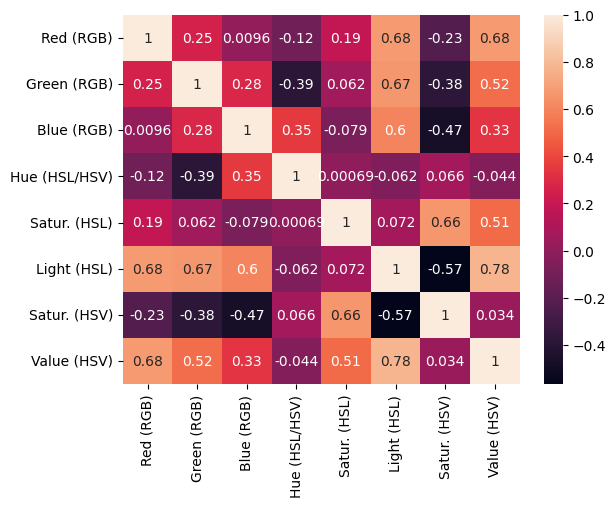

In [11]:
sns.heatmap(data=df_colors.corr(), annot=True)

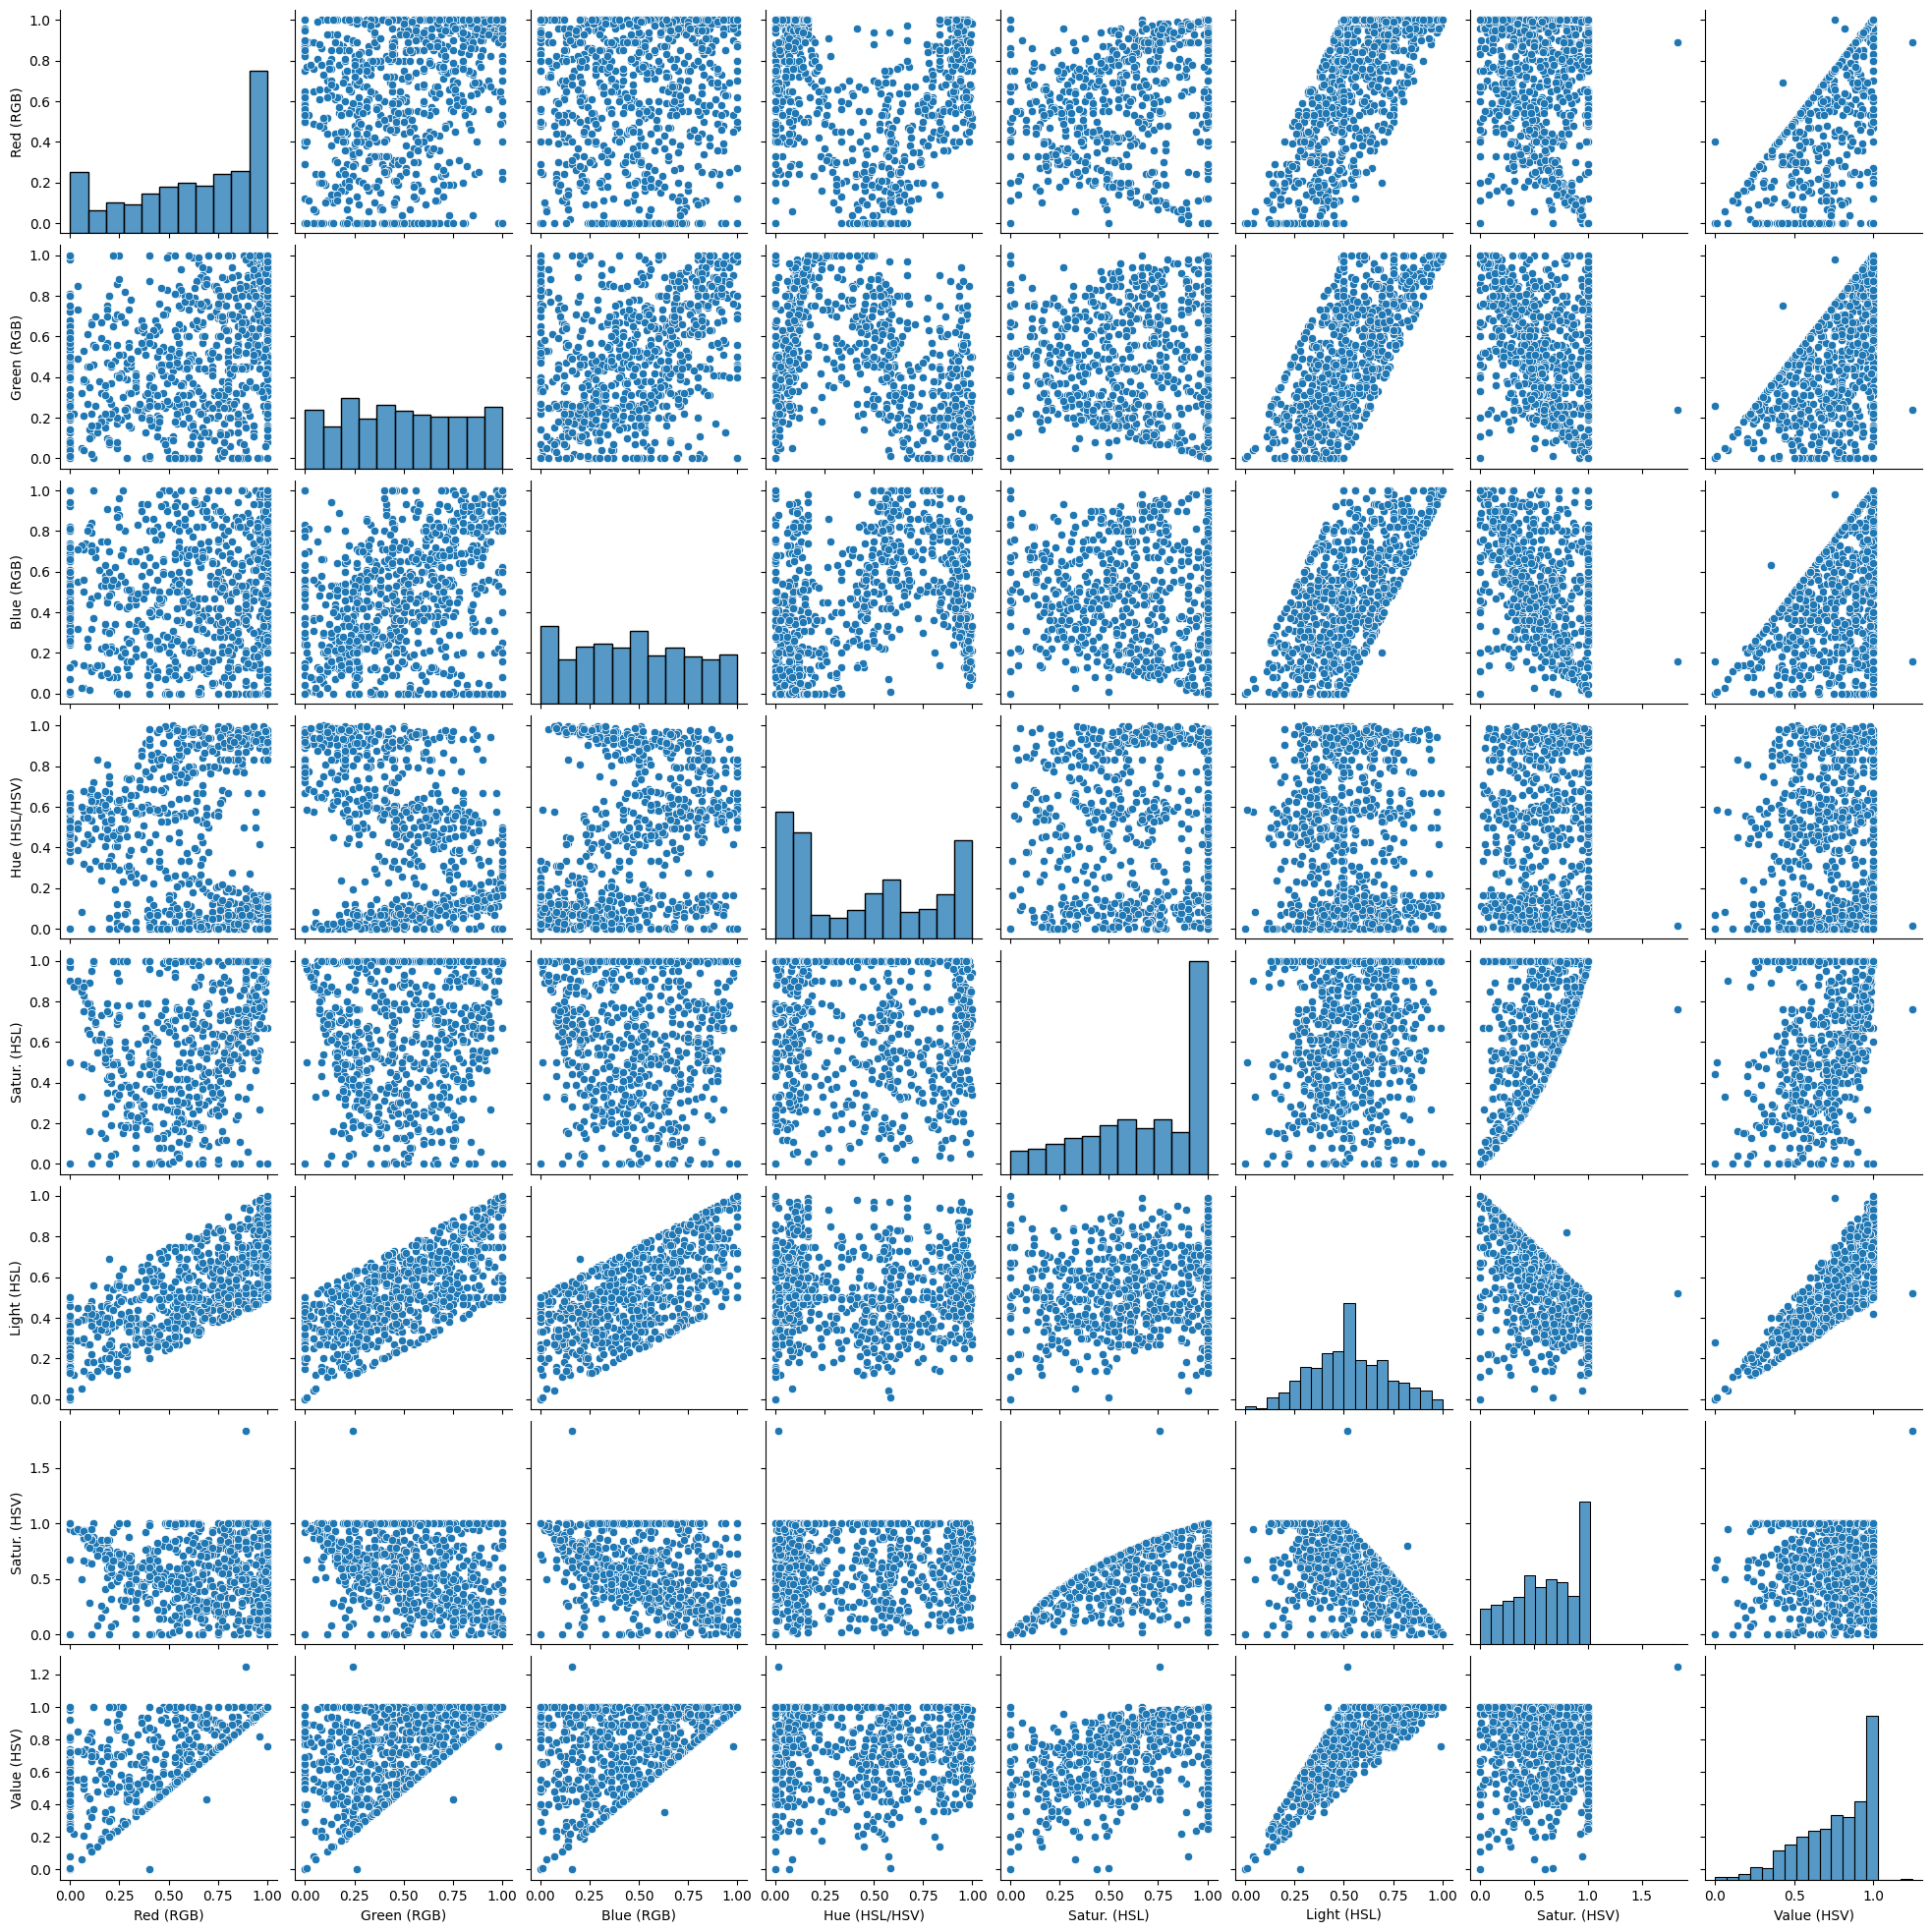

In [12]:
sns.pairplot(df_colors)

Colors are looked up by splitting the query color name by words, then looking for the first exact match with one of the words, but if there are none then it looks for any color with a name containing any of the query words.

For example, consider looking up colors with the word "brown" in their name. Notice that none of the colors are literally "brown" though they all have "brown" in the name.

In [13]:
df_colors.loc[df_colors.Name.str.contains("brown")]

,Name,Hex (RGB),Red (RGB),Green (RGB),Blue (RGB),Hue (HSL/HSV),Satur. (HSL),Light (HSL),Satur. (HSV),Value (HSV),Source
47,bistre brown,#967117,0.59,0.44,0.09,0.119444,0.73,0.34,0.85,0.59,ISCC-NBS
79,brown sugar,#AF6E4D,0.69,0.43,0.30,0.055556,0.39,0.49,0.56,0.69,Crayola
84,burnished brown,#A17A74,0.63,0.48,0.45,0.022222,0.19,0.54,0.28,0.63,Crayola
157,coyote brown,#81613C,0.51,0.38,0.24,0.088889,0.37,0.37,0.52,0.51,colorcode.is
168,dark brown,#654321,0.40,0.26,0.13,0.083333,0.51,0.26,0.67,0.40,X11/Web
209,drab dark brown,#4A412A,0.29,0.25,0.16,0.119444,0.28,0.23,0.43,0.29,Pantone
271,golden brown,#996515,0.60,0.40,0.08,0.100000,0.76,0.34,0.86,0.60,<NA>
596,pullman brown (ups brown),#644117,0.39,0.25,0.09,0.091667,0.63,0.24,0.77,0.39,<NA>
661,rosy brown,#BC8F8F,0.74,0.56,0.56,0.000000,0.25,0.65,0.24,0.74,<NA>
677,saddle brown,#8B4513,0.55,0.27,0.07,0.069444,0.76,0.31,0.86,0.55,<NA>


In [15]:
def colorInfo(color):
    color = color.lower()
    words = [color] if color.count(' ') == 0 else [color] + color.split(' ')
    for word in words:
        try:
            items = df_colors.loc[df_colors.Name == word]
            if len(items) > 0:
                return items
        except:
            continue
    
    for word in words:
        try:
            items = df_colors.loc[df_colors.Name.str.contains(word)]
            if len(items) > 0:
                return items
        except:
            continue
        
    return None

# def rgb(color):
#     info = colorInfo(color)
#     if info is None: return (None, None, None)
#     r = info['Red (RGB)'].values[0]
#     g = info['Green (RGB)'].values[0]
#     b = info['Blue (RGB)'].values[0]
#     return (r, g, b)

def rgbhsv(color):
    info = colorInfo(color)
    if info is None: return (None, None, None, None, None, None)
    r = info['Red (RGB)'].values[0]
    g = info['Green (RGB)'].values[0]
    b = info['Blue (RGB)'].values[0]
    h = info['Hue (HSL/HSV)'].values[0]
    s = info['Satur. (HSV)'].values[0]
    v = info['Value (HSV)'].values[0]
    return (r, g, b, h, s, v)

rgbhsv('brown')

(0.59, 0.44, 0.09, 0.11944444444444445, 0.85, 0.59)

In [16]:
def flatten(x):
    res = []
    for y in x:
        res.extend(y)
    return res

flatten([(1, 2), ('x', 'y')])

[1, 2, 'x', 'y']

In [17]:
df_out['Colors (count)'] = df_out.Color.str.count('/') + 1
df_out = df_out.assign(**{
    'Color 0': [colors[0] for colors in df_out.Color.str.split('/')],
    'Color 1': [colors[1] if len(colors) > 1 else None for colors in df_out.Color.str.split('/')]
}).convert_dtypes(infer_objects=True)
df_out.info()
df_out.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149511 entries, 0 to 149510
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         149511 non-null  string        
 1   Name              106260 non-null  string        
 2   DateTime          149511 non-null  datetime64[ns]
 3   MonthYear         149511 non-null  string        
 4   Date of Birth     149511 non-null  datetime64[ns]
 5   Outcome Type      149485 non-null  string        
 6   Outcome Subtype   68443 non-null   string        
 7   Animal Type       149511 non-null  string        
 8   Sex upon Outcome  149509 non-null  string        
 9   Age upon Outcome  149465 non-null  string        
 10  Breed             149511 non-null  string        
 11  Color             149511 non-null  string        
 12  Colors (count)    149511 non-null  Int64         
 13  Color 0           149511 non-null  string        
 14  Colo

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Colors (count),Color 0,Color 1
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,<NA>,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,2,Brown Tabby,White
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,<NA>,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,2,White,Brown
2,A821648,<NA>,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,<NA>,Other,Unknown,1 year,Raccoon,Gray,1,Gray,<NA>
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,<NA>,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,1,Buff,<NA>
4,A674754,<NA>,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,1,Orange Tabby,<NA>


This cell takes a few minutes to complete

In [18]:
color_vars = 'RGBHSV'

for color_index in ['0', '1']:
    colors = df_out[f'Color {color_index}']
    colors_isna = colors.isna()
    colors_RGBHSV = [rgbhsv(color) if not colors_isna[i] else (None, None, None, None, None, None) for i,color in enumerate(colors)]
    color_columns = []
    for color_var in color_vars:
        color_column = f'Color {color_index} {color_var}'
        color_columns.append(color_column)
        df_out = df_out.assign(**{
            color_column: pd.Series(np.zeros_like(df_out.index)).astype(dtype=float)
        })
    df_out[color_columns] = colors_RGBHSV

df_out

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,...,Color 0 B,Color 0 H,Color 0 S,Color 0 V,Color 1 R,Color 1 G,Color 1 B,Color 1 H,Color 1 S,Color 1 V
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,<NA>,Cat,Neutered Male,2 years,...,0.09,0.119444,0.85,0.59,1.00,1.00,1.00,0.000000,0.00,1.00
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,<NA>,Dog,Neutered Male,1 year,...,1.00,0.000000,0.00,1.00,0.59,0.44,0.09,0.119444,0.85,0.59
2,A821648,<NA>,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,<NA>,Other,Unknown,1 year,...,0.71,0.375000,0.06,0.75,NaN,NaN,NaN,NaN,NaN,NaN
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,<NA>,Dog,Neutered Male,4 months,...,0.50,0.091667,0.50,1.00,NaN,NaN,NaN,NaN,NaN,NaN
4,A674754,<NA>,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,...,0.00,0.083333,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149506,A859974,*Lady Gaga,2022-08-16 11:42:00,Aug 2022,2012-06-21,Adoption,<NA>,Cat,Spayed Female,10 years,...,1.00,0.000000,0.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
149507,A856973,*Suede,2022-06-11 15:39:00,Jun 2022,2021-05-10,Adoption,<NA>,Cat,Spayed Female,1 year,...,1.00,0.666667,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN
149508,A852036,Queen,2022-03-17 17:22:00,Mar 2022,2021-12-08,Adoption,<NA>,Dog,Spayed Female,3 months,...,0.09,0.119444,0.85,0.59,0.00,0.00,0.00,0.000000,0.00,0.00
149509,A852775,A852775,2022-05-18 14:13:00,May 2022,2022-01-31,Adoption,Foster,Cat,Spayed Female,3 months,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Age

The "Age upon Outcome (years)" column is made here

In [77]:
def age_years(age):
    try:
        [number_str, unit] = age.split(' ')
        number = float(number_str)
        if unit in ['years', 'year']:
            return number
        elif unit in ['months', 'month']:
            return number / 12
        elif unit in ['weeks', 'week']:
            return number / 52
        elif unit in ['days', 'day']:
            return number / 365
    except: pass
    return None

df_out['Age upon Outcome (years)'] = [age_years(age) for age in df_out['Age upon Outcome']]
df_out.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,...,Color 0 H,Color 0 S,Color 0 V,Color 1 R,Color 1 G,Color 1 B,Color 1 H,Color 1 S,Color 1 V,Age upon Outcome (years)
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,<NA>,Cat,Neutered Male,2 years,...,0.119444,0.85,0.59,1.00,1.00,1.00,0.000000,0.00,1.00,2.000000
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,<NA>,Dog,Neutered Male,1 year,...,0.000000,0.00,1.00,0.59,0.44,0.09,0.119444,0.85,0.59,1.000000
2,A821648,<NA>,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,<NA>,Other,Unknown,1 year,...,0.375000,0.06,0.75,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,<NA>,Dog,Neutered Male,4 months,...,0.091667,0.50,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.333333
4,A674754,<NA>,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,...,0.083333,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.016438


## Sex

Male or female are classified in two columns since some animals are of unknown sex

In [78]:
# sex and neuter/spay columns

sex_male = df_out['Sex upon Outcome'].str.endswith(' Male')
sex_female = df_out['Sex upon Outcome'].str.endswith(' Female')
neutered_or_spayed = df_out['Sex upon Outcome'].str.startswith('Neutered') | df_out['Sex upon Outcome'].str.startswith('Spayed')

df_out['Male'] = sex_male
df_out['Female'] = sex_female
df_out['NeuteredOrSpayed'] = neutered_or_spayed
df_out = df_out.convert_dtypes(convert_boolean=True)
df_out.info()
df_out.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149511 entries, 0 to 149510
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Animal ID                 149511 non-null  string        
 1   Name                      106260 non-null  string        
 2   DateTime                  149511 non-null  datetime64[ns]
 3   MonthYear                 149511 non-null  string        
 4   Date of Birth             149511 non-null  datetime64[ns]
 5   Outcome Type              149485 non-null  string        
 6   Outcome Subtype           68443 non-null   string        
 7   Animal Type               149511 non-null  string        
 8   Sex upon Outcome          149509 non-null  string        
 9   Age upon Outcome          149465 non-null  string        
 10  Breed                     149511 non-null  string        
 11  Color                     149511 non-null  string        
 12  Co

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,...,Color 1 R,Color 1 G,Color 1 B,Color 1 H,Color 1 S,Color 1 V,Age upon Outcome (years),Male,Female,NeuteredOrSpayed
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,<NA>,Cat,Neutered Male,2 years,...,1.0,1.0,1.0,0.0,0.0,1.0,2.0,True,False,True
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,<NA>,Dog,Neutered Male,1 year,...,0.59,0.44,0.09,0.119444,0.85,0.59,1.0,True,False,True
2,A821648,<NA>,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,<NA>,Other,Unknown,1 year,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1.0,False,False,False
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,<NA>,Dog,Neutered Male,4 months,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.333333,True,False,True
4,A674754,<NA>,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.016438,True,False,False
5,A659412,Princess,2020-10-05 14:37:00,Oct 2020,2013-03-24,Adoption,<NA>,Dog,Spayed Female,7 years,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7.0,False,True,True
6,A814515,Quentin,2020-05-06 07:59:00,May 2020,2018-03-01,Adoption,Foster,Dog,Neutered Male,2 years,...,0.59,0.44,0.09,0.119444,0.85,0.59,2.0,True,False,True
7,A868405,*Leo,2023-03-04 13:38:00,Mar 2023,2020-11-02,Adoption,<NA>,Dog,Neutered Male,2 years,...,1.0,1.0,1.0,0.0,0.0,1.0,2.0,True,False,True
8,A689724,*Donatello,2014-10-18 18:52:00,Oct 2014,2014-08-01,Adoption,<NA>,Cat,Neutered Male,2 months,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.166667,True,False,True
9,A680969,*Zeus,2014-08-05 16:59:00,Aug 2014,2014-06-03,Adoption,<NA>,Cat,Neutered Male,2 months,...,1.0,0.5,0.0,0.083333,1.0,1.0,0.166667,True,False,True


## Adopted?

In [79]:
df_out['Adopted'] = df_out['Outcome Type'].str.find('Adopt') >= 0

In [80]:
def bigCorr_bernoulli(df, independent, dependent):
    return (
        df[[independent, dependent]].groupby(independent).value_counts().div(
        df[[independent]].groupby(independent).value_counts())
    )[:,True]

## Preparing the breeds dataframe

In [81]:
breeds_counts = df_out.Breed.value_counts()
df_breeds = pd.DataFrame(index=breeds_counts.index)
df_breeds = df_breeds.assign(Breed=breeds_counts.index, Count=breeds_counts)
df_breeds

,Breed,Count
Domestic Shorthair Mix,Domestic Shorthair Mix,33260
Domestic Shorthair,Domestic Shorthair,13808
Pit Bull Mix,Pit Bull Mix,9406
Labrador Retriever Mix,Labrador Retriever Mix,7913
Chihuahua Shorthair Mix,Chihuahua Shorthair Mix,6689
...,...,...
Lovebird Mix,Lovebird Mix,1
American Pit Bull Terrier/Pointer,American Pit Bull Terrier/Pointer,1
Dachshund Wirehair/Manchester Terrier,Dachshund Wirehair/Manchester Terrier,1
Norfolk Terrier/Border Terrier,Norfolk Terrier/Border Terrier,1


In [82]:
# Add animal type to the breed
breeds_types = df_out[['Breed', 'Animal Type']].groupby('Breed').value_counts().index
breeds = [breed_type[0] for breed_type in breeds_types]
types = [breed_type[1] for breed_type in breeds_types]
df_breeds_types = pd.DataFrame(data=types, index=breeds, columns=['Type'])
df_breeds_types = df_breeds_types.assign(Breed=breeds)
df_breeds_types = df_breeds_types.drop_duplicates('Breed')
df_breeds = df_breeds.assign(**{'Animal Type': df_breeds_types['Type']})
df_breeds = df_breeds.convert_dtypes(infer_objects=True)
df_breeds

,Breed,Count,Animal Type
Domestic Shorthair Mix,Domestic Shorthair Mix,33260,Cat
Domestic Shorthair,Domestic Shorthair,13808,Cat
Pit Bull Mix,Pit Bull Mix,9406,Dog
Labrador Retriever Mix,Labrador Retriever Mix,7913,Dog
Chihuahua Shorthair Mix,Chihuahua Shorthair Mix,6689,Dog
...,...,...,...
Lovebird Mix,Lovebird Mix,1,Bird
American Pit Bull Terrier/Pointer,American Pit Bull Terrier/Pointer,1,Dog
Dachshund Wirehair/Manchester Terrier,Dachshund Wirehair/Manchester Terrier,1,Dog
Norfolk Terrier/Border Terrier,Norfolk Terrier/Border Terrier,1,Dog


In [83]:
## Adoption likelihood

df_breeds = df_breeds.assign(Adopted=bigCorr_bernoulli(df_out, 'Breed', 'Adopted'))
df_breeds

,Breed,Count,Animal Type,Adopted
Domestic Shorthair Mix,Domestic Shorthair Mix,33260,Cat,0.461425
Domestic Shorthair,Domestic Shorthair,13808,Cat,0.553158
Pit Bull Mix,Pit Bull Mix,9406,Dog,0.431427
Labrador Retriever Mix,Labrador Retriever Mix,7913,Dog,0.546063
Chihuahua Shorthair Mix,Chihuahua Shorthair Mix,6689,Dog,0.483181
...,...,...,...,...
Lovebird Mix,Lovebird Mix,1,Bird,1.000000
American Pit Bull Terrier/Pointer,American Pit Bull Terrier/Pointer,1,Dog,1.000000
Dachshund Wirehair/Manchester Terrier,Dachshund Wirehair/Manchester Terrier,1,Dog,1.000000
Norfolk Terrier/Border Terrier,Norfolk Terrier/Border Terrier,1,Dog,NaN


In [84]:
def means(df_groups, df_individual, independent, dependent):
    df_groups[f'{dependent} (mean)'] = df_individual[[independent, dependent]].groupby(independent).mean()
def stdDevs(df_groups, df_individual, independent, dependent):
    df_groups[f'{dependent} (std dev)'] = df_individual[[independent, dependent]].groupby(independent).std()
def stats(df_groups, df_individual, independent, dependent):
    means(df_groups, df_individual, independent, dependent)
    stdDevs(df_groups, df_individual, independent, dependent)

for color_index in ['0', '1']:
    for color_feature in color_vars:
        stats(df_breeds, df_out, 'Breed', f'Color {color_index} {color_feature}')

df_breeds.head()

,Breed,Count,Animal Type,Adopted,Color 0 R (mean),Color 0 R (std dev),Color 0 G (mean),Color 0 G (std dev),Color 0 B (mean),Color 0 B (std dev),...,Color 1 G (mean),Color 1 G (std dev),Color 1 B (mean),Color 1 B (std dev),Color 1 H (mean),Color 1 H (std dev),Color 1 S (mean),Color 1 S (std dev),Color 1 V (mean),Color 1 V (std dev)
Domestic Shorthair Mix,Domestic Shorthair Mix,33260,Cat,0.461425,0.439476,0.412274,0.322711,0.323957,0.286948,0.413041,...,0.877082,0.302012,0.879391,0.315389,0.028722,0.115326,0.080351,0.259559,0.919515,0.250093
Domestic Shorthair,Domestic Shorthair,13808,Cat,0.553158,0.451115,0.412934,0.331264,0.324532,0.293482,0.413847,...,0.86943,0.310584,0.869237,0.327447,0.027946,0.112799,0.08027,0.259781,0.910416,0.263834
Pit Bull Mix,Pit Bull Mix,9406,Dog,0.431427,0.513666,0.403283,0.418784,0.381554,0.476534,0.439715,...,0.842194,0.318559,0.830459,0.350301,0.034014,0.115363,0.124423,0.298265,0.893498,0.257412
Labrador Retriever Mix,Labrador Retriever Mix,7913,Dog,0.546063,0.409771,0.421755,0.329495,0.388036,0.181561,0.323025,...,0.858574,0.298292,0.82045,0.350653,0.018031,0.055216,0.097087,0.249907,0.885889,0.270776
Chihuahua Shorthair Mix,Chihuahua Shorthair Mix,6689,Dog,0.483181,0.609789,0.370759,0.493648,0.361854,0.356013,0.369441,...,0.737161,0.330531,0.64574,0.398973,0.038664,0.059027,0.221868,0.320446,0.797511,0.301396


In [85]:
# sns.pairplot(data=df_breeds)

In [86]:
df_breeds_info = pd.read_csv('dog breeds_enriched_20210503.csv').convert_dtypes(infer_objects=True)
df_breeds_info.info()
df_breeds_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Breed               195 non-null    string 
 1   Breed Group AKC     195 non-null    string 
 2   Breed Group CKC     195 non-null    string 
 3   Breed Group UKC     195 non-null    string 
 4   CKC Subgroup        194 non-null    string 
 5   height_low_inches   195 non-null    Float64
 6   height_high_inches  195 non-null    Float64
 7   average height      195 non-null    Float64
 8   weight_low_lbs      195 non-null    Float64
 9   weight_high_lbs     195 non-null    Int64  
 10  average weight      195 non-null    Float64
 11  Lifespan Low        194 non-null    Int64  
 12  Lifespan High       194 non-null    Int64  
 13  average lifespan    195 non-null    Float64
dtypes: Float64(6), Int64(3), string(5)
memory usage: 23.2 KB


,Breed,Breed Group AKC,Breed Group CKC,Breed Group UKC,CKC Subgroup,height_low_inches,height_high_inches,average height,weight_low_lbs,weight_high_lbs,average weight,Lifespan Low,Lifespan High,average lifespan
0,Affenpinscher,Toy Group,Group 5: Pinschers and Schnauzers,Companion Dog,5-B: Small Pinschers and Schnauzers,9.0,12.0,10.5,8.0,12,10.0,12,15,13.5
1,Afghan Hound,Hound Group,Group 8: Sighthound Breeds,Sighthound & Pariah,8-B: Long Haired Sighthounds,25.0,27.0,26.0,50.0,60,55.0,12,15,13.5
2,Aidi,Not Recognized,Not Recognized,Guardian Dog,Not Recognized,20.0,24.5,22.25,50.0,55,52.5,12,13,12.5
3,Airedale Terrier,Terrier Group,Group 6: Terrier Breeds,Terrier,6-A: Large Terriers,22.0,24.0,23.0,45.0,45,45.0,11,14,12.5
4,Akbash Dog,Not Recognized,Group 9: Large Guardian Pastoral/Mountain Dogs,Guardian Dog,None,27.0,34.0,30.5,75.0,140,107.5,9,11,10.0


/opt/homebrew/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/opt/homebrew/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/opt/homebrew/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/opt/homebrew/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.In

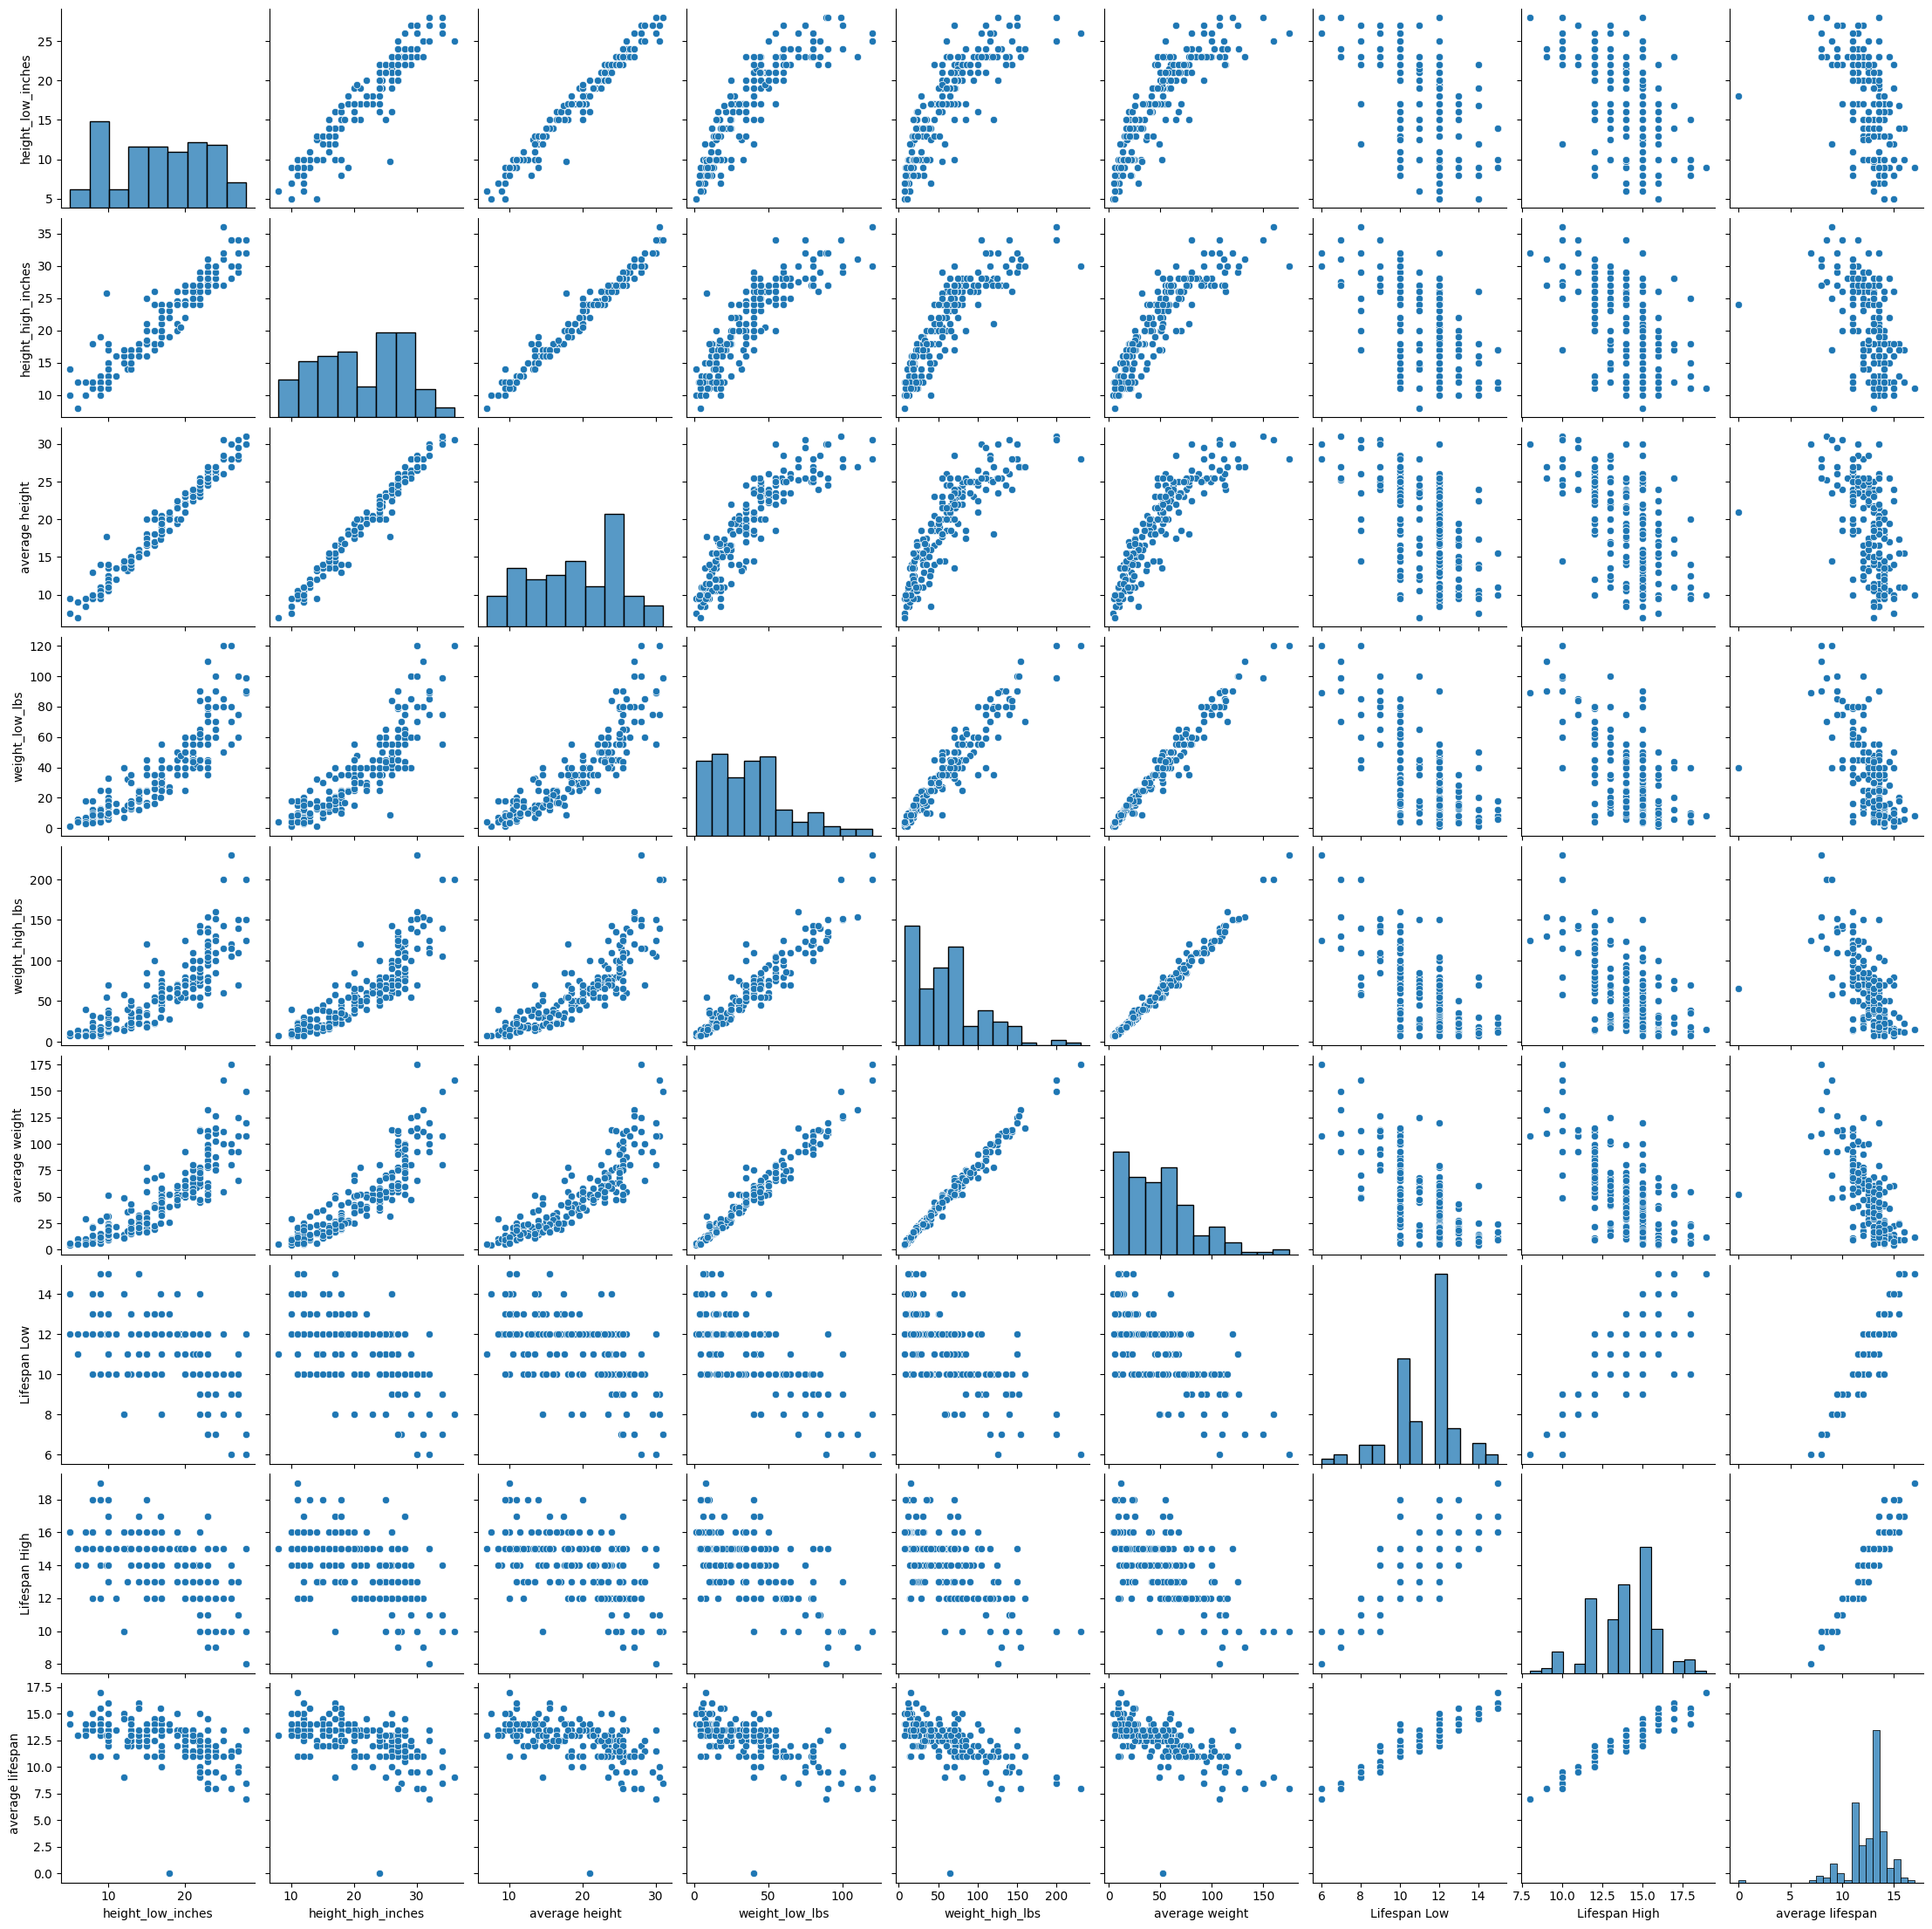

In [87]:
sns.pairplot(data=df_breeds_info)

In [88]:
breeds_names_lower = df_breeds_info.Breed.str.lower()

def findBreedInfoName(breed):
    breed = breed.lower()
    
    info = df_breeds_info.Breed.loc[breeds_names_lower.str.contains(breed)]
    if len(info) > 0: return info.values[0]
    
    for word in breed.split(' '):
        info = df_breeds_info.Breed.loc[breeds_names_lower.str.contains(word)]
        if len(info) > 0: return info.values[0]
    
    return None

In [89]:
df_out_with_breeds_info = df_out.assign(BreedsInfoName=[findBreedInfoName(breed) for breed in df_out.Breed])
df_out_with_breeds_info = df_out_with_breeds_info.merge(df_breeds_info, how='left', left_on='BreedsInfoName', right_on='Breed')
df_out_with_breeds_info.rename(columns={'Breed_x': 'Breed', 'Breed_y': 'Breed (catalog)'}, inplace=True)
df_out_with_breeds_info.info()
df_out_with_breeds_info.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149511 entries, 0 to 149510
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Animal ID                 149511 non-null  string        
 1   Name                      106260 non-null  string        
 2   DateTime                  149511 non-null  datetime64[ns]
 3   MonthYear                 149511 non-null  string        
 4   Date of Birth             149511 non-null  datetime64[ns]
 5   Outcome Type              149485 non-null  string        
 6   Outcome Subtype           68443 non-null   string        
 7   Animal Type               149511 non-null  string        
 8   Sex upon Outcome          149509 non-null  string        
 9   Age upon Outcome          149465 non-null  string        
 10  Breed                     149511 non-null  string        
 11  Color                     149511 non-null  string        
 12  Co

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,...,CKC Subgroup,height_low_inches,height_high_inches,average height,weight_low_lbs,weight_high_lbs,average weight,Lifespan Low,Lifespan High,average lifespan
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,<NA>,Cat,Neutered Male,2 years,...,11-A: Pointing Dogs,21.0,26.0,23.5,45.0,70,57.5,10,12,11.0
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,<NA>,Dog,Neutered Male,1 year,...,12-A: Americas and Caribbean Breeds,5.0,10.0,7.5,1.0,7,4.0,14,16,15.0
2,A821648,<NA>,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,<NA>,Other,Unknown,1 year,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,<NA>,Dog,Neutered Male,4 months,...,9-A: 9-A Large Mountain/Pastoral Dogs Shepherd...,27.0,29.0,28.0,100.0,150,125.0,11,13,12.0
4,A674754,<NA>,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,...,11-A: Pointing Dogs,21.0,26.0,23.5,45.0,70,57.5,10,12,11.0


In [90]:
df_breeds_with_info = df_breeds.assign(BreedsInfoName=[findBreedInfoName(breed) for breed in df_breeds.Breed])
df_breeds_with_info = df_breeds_with_info.merge(df_breeds_info, how='left', left_on='BreedsInfoName', right_on='Breed')
df_breeds_with_info.rename(columns={'Breed_x': 'Breed', 'Breed_y': 'Breed (catalog)'}, inplace=True)
df_breeds_with_info.info()
df_breeds_with_info.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2833 entries, 0 to 2832
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Breed                2833 non-null   string 
 1   Count                2833 non-null   Int64  
 2   Animal Type          2833 non-null   string 
 3   Adopted              2088 non-null   float64
 4   Color 0 R (mean)     2721 non-null   Float64
 5   Color 0 R (std dev)  1698 non-null   float64
 6   Color 0 G (mean)     2721 non-null   Float64
 7   Color 0 G (std dev)  1698 non-null   float64
 8   Color 0 B (mean)     2721 non-null   Float64
 9   Color 0 B (std dev)  1698 non-null   float64
 10  Color 0 H (mean)     2721 non-null   Float64
 11  Color 0 H (std dev)  1698 non-null   float64
 12  Color 0 S (mean)     2721 non-null   Float64
 13  Color 0 S (std dev)  1698 non-null   float64
 14  Color 0 V (mean)     2721 non-null   Float64
 15  Color 0 V (std dev)  1698 non-null   f

,Breed,Count,Animal Type,Adopted,Color 0 R (mean),Color 0 R (std dev),Color 0 G (mean),Color 0 G (std dev),Color 0 B (mean),Color 0 B (std dev),...,CKC Subgroup,height_low_inches,height_high_inches,average height,weight_low_lbs,weight_high_lbs,average weight,Lifespan Low,Lifespan High,average lifespan
0,Domestic Shorthair Mix,33260,Cat,0.461425,0.439476,0.412274,0.322711,0.323957,0.286948,0.413041,...,11-A: Pointing Dogs,21.0,26.0,23.5,45.0,70,57.5,10,12,11.0
1,Domestic Shorthair,13808,Cat,0.553158,0.451115,0.412934,0.331264,0.324532,0.293482,0.413847,...,11-A: Pointing Dogs,21.0,26.0,23.5,45.0,70,57.5,10,12,11.0
2,Pit Bull Mix,9406,Dog,0.431427,0.513666,0.403283,0.418784,0.381554,0.476534,0.439715,...,4-B: Bull-and-Terrier Breeds,17.0,22.0,19.5,30.0,75,52.5,10,12,11.0
3,Labrador Retriever Mix,7913,Dog,0.546063,0.409771,0.421755,0.329495,0.388036,0.181561,0.323025,...,11-C: Retrievers and Waterdogs,21.0,25.0,23.0,55.0,80,67.5,10,12,11.0
4,Chihuahua Shorthair Mix,6689,Dog,0.483181,0.609789,0.370759,0.493648,0.361854,0.356013,0.369441,...,12-A: Americas and Caribbean Breeds,5.0,10.0,7.5,1.0,7,4.0,14,16,15.0


In [91]:
df_out_with_breeds_info['Est. lifespan remaining'] = df_out_with_breeds_info['average lifespan'] - df_out_with_breeds_info['Age upon Outcome (years)']
df_out_with_breeds_info['Est. lifespan remaining'] = df_out_with_breeds_info['Est. lifespan remaining'].astype(dtype=float)
df_out_with_breeds_info.info()
df_out_with_breeds_info['Est. lifespan remaining']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149511 entries, 0 to 149510
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Animal ID                 149511 non-null  string        
 1   Name                      106260 non-null  string        
 2   DateTime                  149511 non-null  datetime64[ns]
 3   MonthYear                 149511 non-null  string        
 4   Date of Birth             149511 non-null  datetime64[ns]
 5   Outcome Type              149485 non-null  string        
 6   Outcome Subtype           68443 non-null   string        
 7   Animal Type               149511 non-null  string        
 8   Sex upon Outcome          149509 non-null  string        
 9   Age upon Outcome          149465 non-null  string        
 10  Breed                     149511 non-null  string        
 11  Color                     149511 non-null  string        
 12  Co

0          9.000000
1         14.000000
2               NaN
3         11.666667
4         10.983562
            ...    
149506          NaN
149507    14.000000
149508    12.750000
149509    14.750000
149510    10.833333
Name: Est. lifespan remaining, Length: 149511, dtype: float64

In [92]:
df_out.to_pickle('df_out.pkl')
df_breeds.to_pickle('df_breeds.pkl')
df_out_with_breeds_info.to_pickle('df_out_with_breeks_info.pkl')
df_breeds_with_info.to_pickle('df_breeds_with_info.pkl')

Data frames can now be quickly loaded for analysis

In [93]:
df_out = pd.read_pickle('df_out.pkl')
df_breeds = pd.read_pickle('df_breeds.pkl')
df_out_with_breeds_info = pd.read_pickle('df_out_with_breeks_info.pkl')
df_breeds_with_info = pd.read_pickle('df_breeds_with_info.pkl')
df_out.info()
df_out.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149511 entries, 0 to 149510
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Animal ID                 149511 non-null  string        
 1   Name                      106260 non-null  string        
 2   DateTime                  149511 non-null  datetime64[ns]
 3   MonthYear                 149511 non-null  string        
 4   Date of Birth             149511 non-null  datetime64[ns]
 5   Outcome Type              149485 non-null  string        
 6   Outcome Subtype           68443 non-null   string        
 7   Animal Type               149511 non-null  string        
 8   Sex upon Outcome          149509 non-null  string        
 9   Age upon Outcome          149465 non-null  string        
 10  Breed                     149511 non-null  string        
 11  Color                     149511 non-null  string        
 12  Co

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,...,Color 1 G,Color 1 B,Color 1 H,Color 1 S,Color 1 V,Age upon Outcome (years),Male,Female,NeuteredOrSpayed,Adopted
0,A794011,Chunk,2019-05-08 18:20:00,May 2019,2017-05-02,Rto-Adopt,<NA>,Cat,Neutered Male,2 years,...,1.0,1.0,0.0,0.0,1.0,2.0,True,False,True,True
1,A776359,Gizmo,2018-07-18 16:02:00,Jul 2018,2017-07-12,Adoption,<NA>,Dog,Neutered Male,1 year,...,0.44,0.09,0.119444,0.85,0.59,1.0,True,False,True,True
2,A821648,<NA>,2020-08-16 11:38:00,Aug 2020,2019-08-16,Euthanasia,<NA>,Other,Unknown,1 year,...,<NA>,<NA>,<NA>,<NA>,<NA>,1.0,False,False,False,False
3,A720371,Moose,2016-02-13 17:59:00,Feb 2016,2015-10-08,Adoption,<NA>,Dog,Neutered Male,4 months,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.333333,True,False,True,True
4,A674754,<NA>,2014-03-18 11:47:00,Mar 2014,2014-03-12,Transfer,Partner,Cat,Intact Male,6 days,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.016438,True,False,False,False
